# Lagaris Problem 1: 1st-Order Linear ODE IVP

## Introduction

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
\frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

Rewritten in standard form:

\begin{equation}
G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The domain is $[0,1]$. The initial condition is:

\begin{equation}
\psi(0)=1
\end{equation}

The analytical solution and its first derivative are:

\begin{equation}
\psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

\begin{equation}
\frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

## Setup

In [1]:
# Import standard Python modules.
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
from nnde.differentialequation.ode.ode1ivp import ODE1IVP

## Create the differential equation object from the problem definition file:

In [3]:
eq_name = 'lagaris_01'
ode = ODE1IVP(eq_name)

## Create the training data.

In [4]:
xmin = 0
xmax = 1
nx = 11
xt = np.linspace(xmin, xmax, nx)

## Compute the analytical solution.

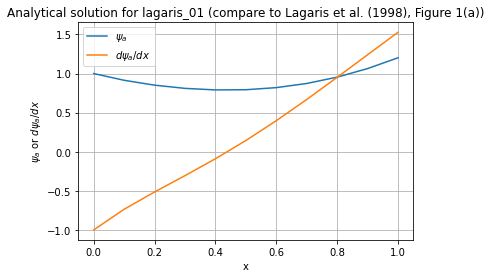

In [5]:
Ya = np.zeros(nx)
dYa_dx = np.zeros(nx)
for i in range(nx):
    Ya[i] = ode.Ya(xt[i])
    dYa_dx[i] = ode.dYa_dx(xt[i])

plt.plot(xt, Ya, label="$\psi_a$")
plt.plot(xt, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s (compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Create and train the network (delta rule).

In [6]:
trainalg = 'delta'
net1 = NNODE1IVP(ode, nhid=10)
opts = {}
opts['maxepochs'] = 1000
np.random.seed(0)
print(datetime.datetime.now())
%timeit -n 1 -r 1 net1.train(xt, trainalg=trainalg, opts=opts)

2021-05-23 11:33:15.010281
391 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Compute the solution at the training points.

In [7]:
Yt = net1.run(xt)
dYt_dx = net1.run_derivative(xt)

## Plot the trained solution.

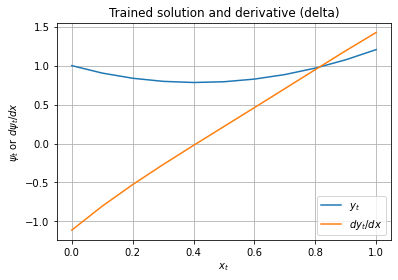

In [8]:
plt.plot(xt, Yt, label='$y_t$')
plt.plot(xt, dYt_dx, label='$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel("$\psi_t$ or $d\psi_t/dx$")
plt.grid()
plt.legend()
plt.title("Trained solution and derivative (%s)" % trainalg);

## Plot the error in the trained solution.

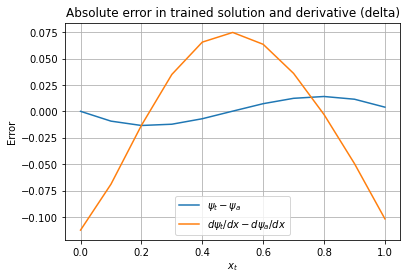

In [9]:
plt.plot(xt, Yt - Ya, label='$\psi_t-\psi_a$')
plt.plot(xt, dYt_dx - dYa_dx, label='$d\psi_t/dx-d\psi_a/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Absolute error in trained solution and derivative (%s)" % trainalg);

## Create and train the network (BFGS).

In [10]:
trainalg = 'BFGS'
net5 = NNODE1IVP(ode, nhid=10)
opts = {}
np.random.seed(0)
print(datetime.datetime.now())
%timeit -n 1 -r 1 net5.train(xt, trainalg=trainalg, opts=opts)
#print(net5.res)

2021-05-23 11:33:15.849096
1.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Compute the solution at the training points.

In [11]:
Yt = net5.run(xt)
dYt_dx = net5.run_derivative(xt)

## Plot the trained solution.

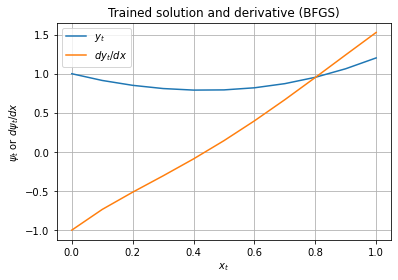

In [12]:
plt.plot(xt, Yt, label='$y_t$')
plt.plot(xt, dYt_dx, label='$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel("$\psi_t$ or $d\psi_t/dx$")
plt.grid()
plt.legend()
plt.title("Trained solution and derivative (%s)" % trainalg);

## Plot the error in the trained solution.

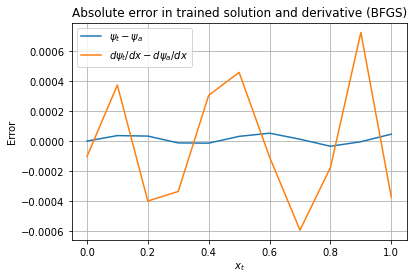

In [13]:
plt.plot(xt, Yt - Ya, label='$\psi_t-\psi_a$')
plt.plot(xt, dYt_dx - dYa_dx, label='$d\psi_t/dx-d\psi_a/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Absolute error in trained solution and derivative (%s)" % trainalg);

## References

Isaac Elias Lagaris, Aristidis Likas, and Dimitrios I. Fotiadis, "Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", *IEEE Transactions on Neural Networks* **9**(5), pp. 987-999, 1998